In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import linalg

In [9]:
r0 = np.random.randint(-100,100,3)
r1 = np.random.randint(-100,100,3)
r2 = np.random.randint(-100,100,3)
r3 = np.random.randint(-100,100,3)

g = np.random.randint(-100,100,3)

print(np.cross(  r0 + r1 + r2 + r3, g  ))

print(np.cross( r0, g  ) + np.cross( r1, g  ) + np.cross( r2, g  ) + np.cross( r3, g  ))

[  1348 -23060  -3570]
[  1348 -23060  -3570]


# Predictive model control

We start with the dynamical model:

\begin{equation}
\begin{cases}
m\mathbf{\ddot{p}} = \sum_i^4 \mathbf{f}_i + m\mathbf{g} \\
I\dot{\omega} = \sum_i^4 \mathbf{r_i}\times \mathbf{f_i}
\end{cases}
\end{equation}

The robot orientation is expressed as a vector ZYX Euler angles $(\phi,\theta, \psi)$ (roll, pitch yaw), and the matrix rotation is

\begin{equation}
R = R_z(\psi)R_y(\theta)R_x(\phi)
\end{equation}

The angular velocity in the word coordinates can be found from the rate of change of this angles, and it can be approximated by:

\begin{equation}
\begin{pmatrix}
\dot{\phi} \\
\dot{\theta} \\
\dot{\psi}
\end{pmatrix} = R_z^T(\psi)\mathbf{\omega}
\end{equation}

where $\omega$ is the angular velocity. We transform everything into the worlds reference system, for instance the intertia as:

\begin{equation}
I = RI^BR^T \approx R_zI^B R_z^T
\end{equation}

which the approximation works for small roll and pitch angles.

The dynamical model can be written as:

\begin{equation}
\frac{d}{dt}\mathbf{x} = A\mathbf{x} + B\mathbf{u}
\end{equation}

where the variable $\mathbf{x}$ is the state variable, a vector with size $13$, defined as:

\begin{equation}
\mathbf{x} = \begin{pmatrix}
\Theta \\
\mathbf{p} \\
\omega \\
\dot{\mathbf{p}} \\
g
\end{pmatrix}
\end{equation}


where $g$ is the constant $9.8m/s^2$ to include gravity, and $\mathbf{u}$ are the forces:

\begin{equation}
\mathbf{u} = \begin{pmatrix}
\mathbf{f_0} \\
\mathbf{f_1} \\
\mathbf{f_2} \\
\mathbf{f_3}\\
\end{pmatrix}
\end{equation}

The matrix $A$ with size $13 \times 13$ is:

\begin{equation}
A = \begin{pmatrix}
0^3  &  0^3 & R^T_z & 0^3 & (0,0,0)^T \\
0^3  &  0^3 & 0^3   & 1^3 & (0,0,0)^T \\
0^3  &  0^3 & 0^3   & 0^3 & (0,0,0)^T \\
0^3  &  0^3 & 0^3   & 0^3 & (0,0,-1)^T \\
(0,0,0)    &  (0,0,0)   & (0,0,0)     & (0,0,0)   &  0
\end{pmatrix}
\end{equation}

and $B$ is a matrix with size $13x3n$ where $n$ is the number of feet in the ground. For 4 feets, we have

\begin{equation}
B = \begin{pmatrix}
0^3  &  0^3 & 0^3 & 0^3 \\
0^3  &  0^3 & 0^3 & 0^3 \\
\hat{I}^{-1}\mathbf{r}_0\times  &  \hat{I}^{-1}\mathbf{r}_1\times  & \hat{I}^{-1}\mathbf{r}_2\times  & \hat{I}^{-1}\mathbf{r}_3\times  \\
(1/m)1^3 & (1/m)1^3 & (1/m)1^3 & (1/m)1^3 \\
0^{1\times3} & 0^{1\times3} & 0^{1\times3} & 0^{1\times3}
\end{pmatrix}
\end{equation}

where the matrix \hat{I}^{-1} is the inverse of the transformed inertia matrix:

\begin{equation}
\hat{I} = R_z I R_z^T
\end{equation}

The matrices $A$ and $B$ only depend on the angle $yaw$ and the feet positions $\mathbf{r_n}$. If these can be computed ahead of time, the dynamics become linear time-varying, which is suitable for convex model predictive control.

In [2]:
I_ = np.array([[1,   0.1, 0.1],        # inertia matrix
              [0.1, 1,   0.1],
              [0.1, 0.1,   1]])


m = 2 # mass


def getRz(yaw):
    Rz = np.array([[np.cos(yaw),  np.sin(yaw), 0 ],
                   [-np.sin(yaw), np.cos(yaw), 0],
                   [0           , 0          , 1]])

    return Rz



def getAmatrix(yaw):
    Rz = getRz(yaw)
    O3 = np.zeros([3,3])
    I3 = np.eye(3)

    O3H = np.array([0,0,0])
    O3V = np.array([[0,0,0]]).T
    
    G3V = np.array([[0,0,-1]]).T

    A = np.vstack([  np.hstack( [O3,  O3,  Rz.T, O3, O3V]),
                     np.hstack( [O3,  O3,  O3,   I3, O3V]), 
                     np.hstack( [O3,  O3,  O3,   O3, O3V]),
                     np.hstack( [O3,  O3,  O3,   O3, G3V]),
                     np.hstack( [O3H, O3H, O3H, O3H, 0])])
    return A


def getCrossProduct(r):
    rx = np.array([[0,   -r[2],  r[1]],        # cross product
                  [r[2],  0,    -r[0]],
                  [-r[1], r[0],   0]])
    return rx

def getBmatrix(yaw, r0, r1, r2, r3):
    Rz = getRz(yaw)
    
    It_ = Rz.dot(I_).dot(Rz.T)
    It_inv = np.linalg.inv(It_)
    
    r0x = getCrossProduct(r0)
    r1x = getCrossProduct(r1)
    r2x = getCrossProduct(r2)
    r3x = getCrossProduct(r3)

    
    O3 = np.zeros([3,3])
    O3H = np.array([0,0,0])
    O3V = np.array([[0,0,0]]).T
    
    Idivm = np.eye(3)/m
        
    B = np.vstack([  np.hstack( [O3,  O3, O3, O3]), 
                     np.hstack( [O3,  O3, O3, O3]),
                     np.hstack( [It_inv.dot(r0x), It_inv.dot(r1x), It_inv.dot(r2x), It_inv.dot(r3x) ]),
                     np.hstack( [Idivm, Idivm, Idivm, Idivm] ),
                     np.hstack( [O3H, O3H, O3H, O3H] )
                  ])
    
    return B
    
A = getAmatrix(0)
print(A)
#B = getBmatrix(0, [1,1,0], [1,-1,0], [-1,1,0], [-1,-1,0])
B = getBmatrix(0, [0,0,0], [0,0,0], [0,0,0], [0,0,0])

print(B)

x0 = np.zeros(13)
x0[12] = 9.8           # GRAVITY ALWAYS POSITIVE



print(A.dot(x0))

[[ 0.  0.  0.  0.  0.  0.  1. -0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0. 

In [3]:
print(A.shape, B.shape)

((13, 13), (13, 12))


We can predict the next state as:

\begin{equation}
x(t+1) = x(t) + \frac{dx(t)}{dt}\Delta t = x(t) + A\Delta t x(t) + B(t)\Delta tu(t) = (I^{13\times13} + A\Delta t)x(t) + B(t)\Delta tu(t)
\end{equation}

So we define the system:

\begin{equation}
x(t+1) = \hat{A}x(t) + \hat{B(t)}u(t)
\end{equation}

where

\begin{equation}
\hat{A} = I^{13\times13} + A\Delta t \quad \text{and} \quad \hat{B}(t) = B(t)\Delta t
\end{equation}

In [32]:
linalg.expm(np.zeros([3,3]))

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  9.8]
(13, 12)


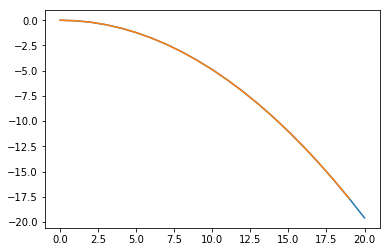

In [87]:
def getADynMatrix(yaw, dt):
    A = getAmatrix(yaw)
    
    #A_dyn = np.eye(13) + A*dt
    A_dyn = linalg.expm(A*dt)
    return A_dyn

def getBdynMatrix(yaw, r0, r1, r2, r3, dt):
    A = getAmatrix(yaw)
    B = getBmatrix(yaw, r0, r1, r2, r3)
    A_dyn = linalg.expm(A*dt)
    print(A)
    return (np.linalg.inv(A) + dt*np.eye(len(A))).dot(B)
    #return B*dt

    
    
def getAandBdynMatrices(yaw, dt, r0, r1, r2, r3):
    A = getAmatrix(yaw)
    B = getBmatrix(yaw, r0, r1, r2, r3)
    
    A_ext_1 = np.hstack([A*dt, B*dt])
        
    A_ext_2 = np.hstack([np.zeros([12,13]), np.zeros([12,12])])
    
    A_ext = np.vstack([A_ext_1, A_ext_2])
    
    
    eA_ext = linalg.expm(A_ext)
    
    
    
    Adyn = eA_ext[:13, :13]
    Bdyn = eA_ext[:13, 13:13+12]
    return Adyn, Bdyn
    
    
dt = 0.1
#A_dyn = getADynMatrix(0, dt)
#Bdyn = getBdynMatrix(0, [0,0,0], [0,0,0], [0,0,0], [0,0,0], dt)

A_dyn, Bdyn = getAandBdynMatrices(0, dt, [0,0,0], [0,0,0], [0,0,0], [0,0,0])


u = np.zeros(12)
u[5] = 0#9.8*m

### Example of free fall
x = [x0]
print(x0)
for t in range(20):
    x.append(A_dyn.dot(x[-1]) + Bdyn.dot(u))


x = np.array(x)
plt.plot(x[:,5])
#plt.plot(x[:,12])


time = np.arange(0,20*dt,dt)
y_fall = 0 - 0.5*9.8*np.power(time,2)

plt.plot(y_fall)

print(Bdyn.shape)

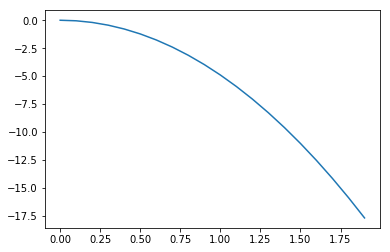

Now we can can minimize:

\begin{equation}
min_{\mathbf{u}} \quad \sum_t^{k-1} \alpha||x(t+1) - x^{ref}(t+1)|| + \beta ||\mathbf{u}_i|| \\ \text{subject to} \begin{cases}
x(t+1) = \hat{A}x(t) \hat{B}(t) u(t)  \\
D_{min} \leq C\mathbf{u}_i \leq D_{max}  \quad\quad\quad\quad \text{for} \quad i =0,..., k-1\\
D_{i}\mathbf{u}_i= 0 
\end{cases}
\end{equation}

The matrices $D_{min}$ and $D_{max}$ ensure that the forces are within the piramid friccion, and $D_{i}$ is a matrix which selects forces corresponding with feet not in contact with the ground at timestep $i$.


We can write this in matrix notation for QP problem:

\begin{equation}
min_{\mathbf{u}} ||A_{qp}x(0) + B_{qp} - X_{ref}|| \\ \text{subject to} \begin{cases}
D_{min} \leq C\mathbf{u}_i \leq D_{max} \\
D_{i}\mathbf{u}_i= 0 
\end{cases}
\end{equation}

where $A_{qp}$ and $B_{qp}$ can be extracted from the fact that

\begin{equation}
\begin{cases}
x[1] = \hat{A}x(0) + \hat{B(0)}u(0) \\
x[2] = \hat{A}x(1) + \hat{B(1)}u(1) = \hat{A}^2x(0) + \hat{A}\hat{B}(0)u(0) + \hat{B}(1)u(1) \\
... \\
x[k] = \hat{A}^k x(0) + \sum_{i=0}^{k-1} \hat{A}^{i}B(k-i-1)u(k-i-1)
\end{cases}
\end{equation}

Then:

\begin{equation}
A_{qp} = 
\begin{pmatrix}
\hat{A} \\
\hat{A}^2 \\
... \\
\hat{A}^k
\end{pmatrix}
\end{equation}

and 

\begin{equation}
B_{qp} = 
\begin{pmatrix}
\hat{B}(0) & 0 & 0 & ...& 0 \\
\hat{A}\hat{B}(0) & \hat{B}(1) & 0 & ...& 0 \\
\hat{A}^2\hat{B}(0) & \hat{A}\hat{B}(1) & \hat{B}(2) & ...& 0 \\
... & ... & ... & ...& ... \\
\hat{A}^{k-1}\hat{B}(0) & \hat{A}^{k-2}\hat{B}(1) & \hat{A}^{k-3}\hat{B}(2) & ...& \hat{B}(k) \\
\end{pmatrix}
\end{equation}


In [35]:
horizont_k = 4
Aqp = ['_']*horizont_k
Bqp = []
for k in range(horizont_k):
    Bqp.append([])
    for j in range(horizont_k):
        Bqp[k].append('_')


for k in range(horizont_k):

    Aqp[k] = 'A'*(k+1)

    
for k in range(horizont_k):
    for j in range(horizont_k):
        Bqp[j][k] = '0'
        if j == k:
            Bqp[j][k] = 'B({:d})'.format(k)
        if j > k:
            Bqp[j][k] =  'A'*(j-k) + 'B({:d})'.format(k)

            
            
            
            
print(Aqp)

for j in range(horizont_k):
    msg = ''
    for k in range(horizont_k):
        msg += Bqp[j][k] + '        '
        
        
    print(msg)

['A', 'AA', 'AAA', 'AAAA']
B(0)        0        0        0        
AB(0)        B(1)        0        0        
AAB(0)        AB(1)        B(2)        0        
AAAB(0)        AAB(1)        AB(2)        B(3)        


In [268]:
def getAqpMatrix(horizont_k, yaw, dt):
    Adyn = getADynMatrix(yaw, dt)
    
    A_qp = np.zeros([13*horizont_k, 13] )
    
    for i in range(1, horizont_k+1):
        A_qp_power =  np.linalg.matrix_power(Adyn, i)
        A_qp[(i-1)*13:i*13] = A_qp_power
        
    return A_qp

def getBqpMatrix(horizont_k, yaw, r0_t, r1_t, r2_t, r3_t, dt):
    Adyn = getADynMatrix(yaw, dt)
    
    B_qp = np.zeros([13 * horizont_k, 12 * horizont_k])
    O12 = np.zeros([13,12])
        
    for col in range(horizont_k):
        B_col = getBdynMatrix(yaw, r0_t[col], r1_t[col], r2_t[col], r3_t[col], dt)
        for row in range(horizont_k):
            if col <= row:
                B_qp[13*row:13*(row+1), 12*col:12*(col+1)] = np.linalg.matrix_power(Adyn, row - col).dot(B_col)


            
    return B_qp  

    
horizont_k = 100
dt = 0.01
yaw = 0
r0t = np.zeros([horizont_k, 3])
r1t = np.zeros([horizont_k, 3])
r2t = np.zeros([horizont_k, 3])
r3t = np.zeros([horizont_k, 3])


Aqp = getAqpMatrix(horizont_k, yaw,  dt)
display(pd.DataFrame(Aqp))

Bqp = getBqpMatrix(horizont_k, yaw, r0t, r1t, r2t, r3t, dt)
display(pd.DataFrame(Bqp))

0    1    2    3    4    5     6     7     8     9     10    11      12
0     1.0  0.0  0.0  0.0  0.0  0.0  0.01  0.00  0.00  0.00  0.00  0.00  0.0000
1     0.0  1.0  0.0  0.0  0.0  0.0  0.00  0.01  0.00  0.00  0.00  0.00  0.0000
2     0.0  0.0  1.0  0.0  0.0  0.0  0.00  0.00  0.01  0.00  0.00  0.00  0.0000
3     0.0  0.0  0.0  1.0  0.0  0.0  0.00  0.00  0.00  0.01  0.00  0.00  0.0000
4     0.0  0.0  0.0  0.0  1.0  0.0  0.00  0.00  0.00  0.00  0.01  0.00  0.0000
5     0.0  0.0  0.0  0.0  0.0  1.0  0.00  0.00  0.00  0.00  0.00  0.01  0.0000
6     0.0  0.0  0.0  0.0  0.0  0.0  1.00  0.00  0.00  0.00  0.00  0.00  0.0000
7     0.0  0.0  0.0  0.0  0.0  0.0  0.00  1.00  0.00  0.00  0.00  0.00  0.0000
8     0.0  0.0  0.0  0.0  0.0  0.0  0.00  0.00  1.00  0.00  0.00  0.00  0.0000
9     0.0  0.0  0.0  0.0  0.0  0.0  0.00  0.00  0.00  1.00  0.00  0.00  0.0000
10    0.0  0.0  0.0  0.0  0.0  0.0  0.00  0.00  0.00  0.00  1.00  0.00  0.0000
11    0.0  0.0  0.0  0.0  0.0  0.0  0.00  0.00  0.00  0.00  0.00  1.00 -0.0100
12    0.0  0.0  0.0  0.0  0.0  0.0  0.00  0.00  0.00  0.00  0.00  0.00  1.0000
13    1.0  0.0  0.0  0.0  0.0  0.0  0.02  0.00  0.00  0.00  0.00  0.00  0.0000
14    0.0  1.0  0.0  0.0  0.0  0.0  0.00  0.02  0.00  0.00  0.00  0.00  0.0000
15    0.0  0.0  1.0  0.0  0.0  0.0  0.00  0.00  0.02  0.00  0.00  0.00  0.0000
16    0.0  0.0  0.0  1.0  0.0  0.0  0.00  0.00  0.00  0.02  0.00  0.00  0.0000
17    0.0  0.0  0.0  0.0  1.0  0.0  0.00  0.00  0.00  0.00  0.02  0.00  0.0000
18    0.0  0.0  0.0  0.0  0.0  1.0  0.00  0.00  0.00  0.00  0.00  0.02 -0.0001
19    0.0  0.0  0.0  0.0  0.0  0.0  1.00  0.00  0.00  0.00  0.00  0.00  0.0000
20    0.0  0.0  0.0  0.0  0.0  0.0  0.00  1.00  0.00  0.00  0.00  0.00  0.0000
21    0.0  0.0  0.0  0.0  0.0  0.0  0.00  0.00  1.00  0.00  0.00  0.00  0.0000
22    0.0  0.0  0.0  0.0  0.0  0.0  0.00  0.00  0.00  1.00  0.00  0.00  0.0000
23    0.0  0.0  0.0  0.0  0.0  0.0  0.00  0.00  0.00  0.00  1.00  0.00  0.0000
24    0.0  0.0  0.0  0.0  0.0  0.0  0.00  0.00  0.00  0.00  0.00  1.00 -0.0200
25    0.0  0.0  0.0  0.0  0.0  0.0  0.00  0.00  0.00  0.00  0.00  0.00  1.0000
26    1.0  0.0  0.0  0.0  0.0  0.0  0.03  0.00  0.00  0.00  0.00  0.00  0.0000
27    0.0  1.0  0.0  0.0  0.0  0.0  0.00  0.03  0.00  0.00  0.00  0.00  0.0000
28    0.0  0.0  1.0  0.0  0.0  0.0  0.00  0.00  0.03  0.00  0.00  0.00  0.0000
29    0.0  0.0  0.0  1.0  0.0  0.0  0.00  0.00  0.00  0.03  0.00  0.00  0.0000
...   ...  ...  ...  ...  ...  ...   ...   ...   ...   ...   ...   ...     ...
1270  0.0  0.0  0.0  0.0  0.0  0.0  0.00  0.00  0.00  1.00  0.00  0.00  0.0000
1271  0.0  0.0  0.0  0.0  0.0  0.0  0.00  0.00  0.00  0.00  1.00  0.00  0.0000
1272  0.0  0.0  0.0  0.0  0.0  0.0  0.00  0.00  0.00  0.00  0.00  1.00 -0.9800
1273  0.0  0.0  0.0  0.0  0.0  0.0  0.00  0.00  0.00  0.00  0.00  0.00  1.0000
1274  1.0  0.0  0.0  0.0  0.0  0.0  0.99  0.00  0.00  0.00  0.00  0.00  0.0000
1275  0.0  1.0  0.0  0.0  0.0  0.0  0.00  0.99  0.00  0.00  0.00  0.00  0.0000
1276  0.0  0.0  1.0  0.0  0.0  0.0  0.00  0.00  0.99  0.00  0.00  0.00  0.0000
1277  0.0  0.0  0.0  1.0  0.0  0.0  0.00  0.00  0.00  0.99  0.00  0.00  0.0000
1278  0.0  0.0  0.0  0.0  1.0  0.0  0.00  0.00  0.00  0.00  0.99  0.00  0.0000
1279  0.0  0.0  0.0  0.0  0.0  1.0  0.00  0.00  0.00  0.00  0.00  0.99 -0.4851
1280  0.0  0.0  0.0  0.0  0.0  0.0  1.00  0.00  0.00  0.00  0.00  0.00  0.0000
1281  0.0  0.0  0.0  0.0  0.0  0.0  0.00  1.00  0.00  0.00  0.00  0.00  0.0000
1282  0.0  0.0  0.0  0.0  0.0  0.0  0.00  0.00  1.00  0.00  0.00  0.00  0.0000
1283  0.0  0.0  0.0  0.0  0.0  0.0  0.00  0.00  0.00  1.00  0.00  0.00  0.0000
1284  0.0  0.0  0.0  0.0  0.0  0.0  0.00  0.00  0.00  0.00  1.00  0.00  0.0000
1285  0.0  0.0  0.0  0.0  0.0  0.0  0.00  0.00  0.00  0.00  0.00  1.00 -0.9900
1286  0.0  0.0  0.0  0.0  0.0  0.0  0.00  0.00  0.00  0.00  0.00  0.00  1.0000
1287  1.0  0.0  0.0  0.0  0.0  0.0  1.00  0.00  0.00  0.00  0.00  0.00  0.0000
1288  0.0  1.0  0.0  0.0  0.0  0.0  0.00  1.00  0.00  0.0

0        1        2        3        4        5        6        7     \
0     0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
1     0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
2     0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
3     0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
4     0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
5     0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
6     0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
7     0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
8     0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
9     0.00500  0.00000  0.00000  0.00500  0.00000  0.00000  0.00500  0.00000   
10    0.00000  0.00500  0.00000  0.00000  0.00500  0.00000  0.00000  0.00500   
11    0.00000  0.00000  0.00500  0.00000  0.00000  0.00500  0.00000  0.00000   
12    0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
13    0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
14    0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
15    0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
16    0.00005  0.00000  0.00000  0.00005  0.00000  0.00000  0.00005  0.00000   
17    0.00000  0.00005  0.00000  0.00000  0.00005  0.00000  0.00000  0.00005   
18    0.00000  0.00000  0.00005  0.00000  0.00000  0.00005  0.00000  0.00000   
19    0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
20    0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
21    0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
22    0.00500  0.00000  0.00000  0.00500  0.00000  0.00000  0.00500  0.00000   
23    0.00000  0.00500  0.00000  0.00000  0.00500  0.00000  0.00000  0.00500   
24    0.00000  0.00000  0.00500  0.00000  0.00000  0.00500  0.00000  0.00000   
25    0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
26    0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
27    0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
28    0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
29    0.00010  0.00000  0.00000  0.00010  0.00000  0.00000  0.00010  0.00000   
...       ...      ...      ...      ...      ...      ...      ...      ...   
1270  0.00500  0.00000  0.00000  0.00500  0.00000  0.00000  0.00500  0.00000   
1271  0.00000  0.00500  0.00000  0.00000  0.00500  0.00000  0.00000  0.00500   
1272  0.00000  0.00000  0.00500  0.00000  0.00000  0.00500  0.00000  0.00000   
1273  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
1274  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
1275  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
1276  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
1277  0.00490  0.00000  0.00000  0.00490  0.00000  0.00000  0.00490  0.00000   
1278  0.00000  0.00490  0.00000  0.00000  0.00490  0.00000  0.00000  0.00490   
1279  0.00000  0.00000  0.00490  0.00000  0.00000  0.00490  0.00000  0.00000   
1280  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
1281  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
1282  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
1283  0.00500  0.00000  0.00000  0.00500  0.00000  0.00000  0.00500  0.00000   
1284  0.00000  0.00500  0.00000  0.00000  0.00500  0.00000  0.00000  0.00500   
1285  0.00000  0.00000  0.00500  0.00000  0.00000  0.00500  0.00000  0.00000   
1286  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
1287  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
1288  0.0

(-0.1, 0.1)

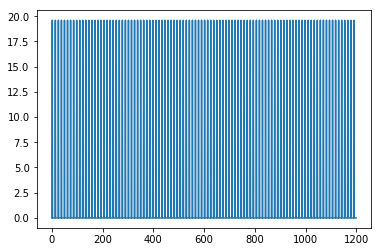

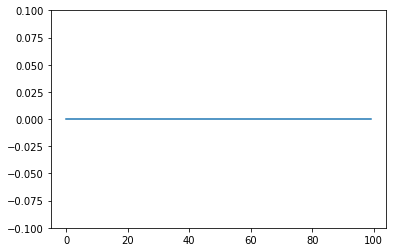

In [285]:
x0 = np.zeros(13)
x0[12] = 9.8
u = np.zeros([horizont_k, 12])
u[:,2] = 9.8*m

U = np.reshape(u, horizont_k * 12 )
plt.figure()
plt.plot(U)

X = Aqp.dot(x0) + Bqp.dot(U) 

x_times = np.reshape(X, [horizont_k, 13])

plt.figure()
plt.plot(x_times[:,5])
plt.ylim([-0.1,0.1])

# Predictive Model Control for position